# Deep Learning Methods for Structural Corporate Finance Models

This notebook demonstrates deep learning methods for solving two dynamic models:
1. **Basic model**: Optimal investment policies
2. **Risky debt model**: Optimal investment and leverage policies

Comparison of Lifetime Reward (LR), Euler Residual (ER), and Bellman Residual (BR) methods.

**Key Difference**: 
- **LR Method**: Uses trajectory data (N samples, T+1 timesteps)
- **ER/BR Methods**: Use flattened i.i.d. data (N×T independent transitions)

---

## Notebook Structure

This notebook is organized into three independent sections:

1. **Section 1: Dataset Creation** - Generate synthetic data for training
2. **Section 2: Training** - Train all models and save checkpoints (depends on Section 1)
3. **Section 3: Analysis & Visualization** - Load checkpoints and create plots (independent, works after restart)

---

# Section 1: Dataset Creation

In [1]:
# =============================================================================
# 1.1 Imports and Setup
# =============================================================================

import sys
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Add project root to path
sys.path.append(os.path.abspath(".."))

from src.economy.data_generator import create_data_generator
from src.economy.parameters import EconomicParams, ShockParams
from src.trainers.config import (
    NetworkConfig, OptimizationConfig, OptimizerConfig, 
    AnnealingConfig, MethodConfig, EarlyStoppingConfig, 
    RiskyDebtConfig, DataConfig, ExperimentConfig
)
from src.trainers.basic import train_basic_lr, train_basic_er, train_basic_br
from src.trainers.risky import train_risky_br

/Users/wangzhaoxuan/Desktop/JPM-TSRL/DL_corp_finance/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# Configure Logging for Notebook Display
from src.utils.logging_config import setup_notebook_logging
setup_notebook_logging('INFO')

Logging configured: level=INFO


In [3]:
# =============================================================================
# 1.2 Run Configuration & Folder Structure
# =============================================================================

# Run name - all results will be stored under results/{RUN_NAME}/
RUN_NAME = "part1-demo"

# Create results folder structure
RESULTS_DIR = os.path.join("..", "results", RUN_NAME)
DATA_DIR = os.path.join(RESULTS_DIR, "data")
FIGURES_DIR = os.path.join(RESULTS_DIR, "figures")
CHECKPOINTS_DIR = os.path.join(RESULTS_DIR, "checkpoints")

for d in [DATA_DIR, FIGURES_DIR, CHECKPOINTS_DIR]:
    os.makedirs(d, exist_ok=True)

print(f"Results directory: {RESULTS_DIR}")
print(f"  - Data:        {DATA_DIR}")
print(f"  - Figures:     {FIGURES_DIR}")
print(f"  - Checkpoints: {CHECKPOINTS_DIR}")

Results directory: ../results/part1-demo
  - Data:        ../results/part1-demo/data
  - Figures:     ../results/part1-demo/figures
  - Checkpoints: ../results/part1-demo/checkpoints


In [4]:
# =============================================================================
# 1.3 Training Configuration
# =============================================================================
# Training profiles for different example use cases:

# Key insights:
# - Sample size = DATA_T * DATA_SIM_BATCH_SIZE * DATA_N_SIM_BATCHES
# - LR has SHORT-HORIZON BIAS if T is too small (keep T >= 32)
# - Reduce trajectories (n_sim_batches) instead of T for speed
# - ER/BR use flattened transitions, so T mainly affects data diversity

# === SELECT PROFILE ===
TRAINING_PROFILE = "FAST_DEBUG"  # Options: "FAST_DEBUG", "BALANCED", "PRODUCTION"

if TRAINING_PROFILE == "FAST_DEBUG":
    # Fast debugging with reasonable horizon (avoid short-horizon bias)
    DATA_T = 64                      # Keep T reasonable for LR
    DATA_SIM_BATCH_SIZE = 10         # Fewer trajectories
    DATA_N_SIM_BATCHES = 5           
    # For basic model training
    TRAIN_BATCH_SIZE = 64            
    TRAIN_N_ITER = 500               
    TRAIN_DECAY = 0.99
    # For risky debt model training
    TRAIN_RISKY_BATCH_SIZE = 64
    TRAIN_RISKY_N_ITER = 500
    
elif TRAINING_PROFILE == "BALANCED":
    # Sample size
    DATA_T = 64                      
    DATA_SIM_BATCH_SIZE = 40         
    DATA_N_SIM_BATCHES = 10 
    # For basic model         
    TRAIN_BATCH_SIZE = 64
    TRAIN_N_ITER = 1000
    TRAIN_DECAY = 0.995
    # For risky debt model training
    TRAIN_RISKY_BATCH_SIZE = 128
    TRAIN_RISKY_N_ITER = 1000    
    
else:  # PRODUCTION
    # Full training for final results
    DATA_T = 64                      # Longer horizon for best LR quality
    DATA_SIM_BATCH_SIZE = 100         # 1600 trajectories
    DATA_N_SIM_BATCHES = 25          
    TRAIN_BATCH_SIZE = 128
    TRAIN_N_ITER = 2000
    TRAIN_DECAY = 0.998
    # For risky debt model training
    TRAIN_RISKY_BATCH_SIZE = 512
    TRAIN_RISKY_N_ITER = 2000        

n_trajectories = DATA_SIM_BATCH_SIZE * DATA_N_SIM_BATCHES
n_transitions = n_trajectories * DATA_T

print(f"Training Profile: {TRAINING_PROFILE}")
print(f"  Trajectories: {n_trajectories}, T={DATA_T}")
print(f"  Flattened transitions: {n_transitions:,}")
print(f"  Training Basic: batch_size={TRAIN_BATCH_SIZE}, n_iter={TRAIN_N_ITER}, decay={TRAIN_DECAY}")
print(f"  Training Risky: batch_size={TRAIN_RISKY_BATCH_SIZE}, n_iter={TRAIN_RISKY_N_ITER}")

Training Profile: FAST_DEBUG
  Trajectories: 50, T=64
  Flattened transitions: 3,200
  Training Basic: batch_size=64, n_iter=500, decay=0.99
  Training Risky: batch_size=64, n_iter=500


In [5]:
# =============================================================================
# 1.4 Data Configuration
# =============================================================================

# Set save_to_disk=True for faster restart (loads cached data)
# Set save_to_disk=False to regenerate data each time (default)
SAVE_DATA_TO_DISK = False

data_config = DataConfig(
    master_seed=(20, 26),
    T=DATA_T,  # Use profile-specific horizon
    sim_batch_size=DATA_SIM_BATCH_SIZE,
    n_sim_batches=DATA_N_SIM_BATCHES,
    auto_compute_bounds=True,
    std_dev_multiplier=3.0,
    k_min_multiplier=0.2,
    k_max_multiplier=4.0,
    cache_dir=DATA_DIR,
    save_to_disk=SAVE_DATA_TO_DISK
)

data_config.print_summary()


DATA CONFIGURATION
                                                        Value
Group      Parameter                                         
Simulation master_seed                               (20, 26)
           T (horizon)                                     64
           sim_batch_size                                  10
           n_sim_batches                                    5
           total_samples                                   50
           N_val                                100 (default)
           N_test                               500 (default)
Bounds     auto_compute_bounds                           True
           std_dev_multiplier (m)                         3.0
           k_min_multiplier                               0.2
           k_max_multiplier                               4.0
Cache      cache_dir               ../results/part1-demo/data
           save_to_disk                                 False



In [6]:
# =============================================================================
# 1.5 Economic Parameters
# =============================================================================

# Base economic parameters (shared across all scenarios)
base_params = EconomicParams()  # Uses defaults

# AR(1) Shock Process (shared across all scenarios)
shock_params = ShockParams(mu=0.0, rho=0.7, sigma=0.15)

# =============================================================================
# SCENARIO DEFINITIONS
# =============================================================================

# Basic Model Scenarios: Vary adjustment cost structure
# All scenarios derive from base_params with specific overrides
BASIC_SCENARIOS = {
    'baseline': {
        'description': 'No adjustment costs',
        'params': base_params.with_overrides(
            cost_convex=0.0,
            cost_fixed=0.0,
            cost_inject_fixed=0.0,
            cost_inject_linear=0.0
        )
    },
    'smooth_cost': {
        'description': 'Convex adjustment costs only',
        'params': base_params.with_overrides(
            cost_convex=0.2,
            cost_fixed=0.0,
            cost_inject_fixed=0.0,
            cost_inject_linear=0.0
        )
    },
    'fixed_cost': {
        'description': 'Fixed adjustment costs only',
        'params': base_params.with_overrides(
            cost_convex=0.0,
            cost_fixed=0.05,
            cost_inject_fixed=0.0,
            cost_inject_linear=0.0
        )
    }
}

# Risky Debt Model: Single baseline scenario
RISKY_SCENARIOS = {
    'baseline': {
        'description': 'Standard risky debt with all cost components',
        'params': base_params.with_overrides(
            cost_convex=0.01,
            cost_fixed=0.01,
            cost_inject_fixed=0.02,
            cost_inject_linear=0.02,
            cost_default=0.4,
            tax=0.3
        )
    }
    # Add more scenarios if needed
}

# Print scenario summary
print("=" * 60)
print("SCENARIO DEFINITIONS")
print("=" * 60)
print(f"\nBase parameters: r={base_params.r_rate}, delta={base_params.delta}, theta={base_params.theta}")
print("\nBasic Model Scenarios:")
for name, scenario in BASIC_SCENARIOS.items():
    p = scenario['params']
    print(f"  {name:12s}: cost_convex={p.cost_convex}, cost_fixed={p.cost_fixed}")
    print(f"               {scenario['description']}")

print("\nRisky Debt Scenarios:")
for name, scenario in RISKY_SCENARIOS.items():
    p = scenario['params']
    print(f"  {name:12s}: cost_convex={p.cost_convex}, cost_fixed={p.cost_fixed}, cost_default={p.cost_default}")
    print(f"               {scenario['description']}")
print("=" * 60)

[INFO] parameters: EconomicParams overrides: cost_convex: 0.0 -> 0.2
[INFO] parameters: EconomicParams overrides: cost_fixed: 0.0 -> 0.05
[INFO] parameters: EconomicParams overrides: cost_convex: 0.0 -> 0.01, cost_fixed: 0.0 -> 0.01, cost_inject_fixed: 0.0 -> 0.02, cost_inject_linear: 0.0 -> 0.02
SCENARIO DEFINITIONS

Base parameters: r=0.04, delta=0.15, theta=0.7

Basic Model Scenarios:
  baseline    : cost_convex=0.0, cost_fixed=0.0
               No adjustment costs
  smooth_cost : cost_convex=0.2, cost_fixed=0.0
               Convex adjustment costs only
  fixed_cost  : cost_convex=0.0, cost_fixed=0.05
               Fixed adjustment costs only

Risky Debt Scenarios:
  baseline    : cost_convex=0.01, cost_fixed=0.01, cost_default=0.4
               Standard risky debt with all cost components


In [7]:
# =============================================================================
# 1.6 Generate Synthetic Data (shared across all scenarios)
# =============================================================================

# Use DataConfig.create_generator()
generator, _, bounds = data_config.create_generator(
    # Use baseline params for data generation (all scenarios train on same data)
    params=base_params,
    shock_params=shock_params,
    verbose=False
)

# Get training data in both formats
traj_data = generator.get_training_dataset()
flat_data = generator.get_flattened_training_dataset(include_debt=True)

# Get validation data
val_traj = generator.get_validation_dataset()
val_flat = generator.get_flattened_validation_dataset(include_debt=True)

print(f"\nTraining: {traj_data['k0'].shape[0]:,} trajectories, {flat_data['k'].shape[0]:,} transitions")
print(f"Validation: {val_traj['k0'].shape[0]:,} trajectories, {val_flat['k'].shape[0]:,} transitions")

# Store bounds for later use
k_bounds = bounds['k']
logz_bounds = bounds['log_z']
b_bounds = bounds['b']

print(f"\nBounds: k={k_bounds}, log_z={logz_bounds}, b={b_bounds}")
print("\nNote: All scenarios will use this same dataset for training.")

2026-02-01 17:00:46.068931: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2026-02-01 17:00:46.069140: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-01 17:00:46.069152: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-02-01 17:00:46.069439: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-01 17:00:46.069462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



Training: 50 trajectories, 3,200 transitions
Validation: 100 trajectories, 6,400 transitions

Bounds: k=(15.447022976557044, 308.94045953114085), log_z=(-0.6301260378126043, 0.6301260378126043), b=(0.0, 188.9954691887226)

Note: All scenarios will use this same dataset for training.


Saving figure to ../results/part1-demo/figures/data_format_comparison.png...


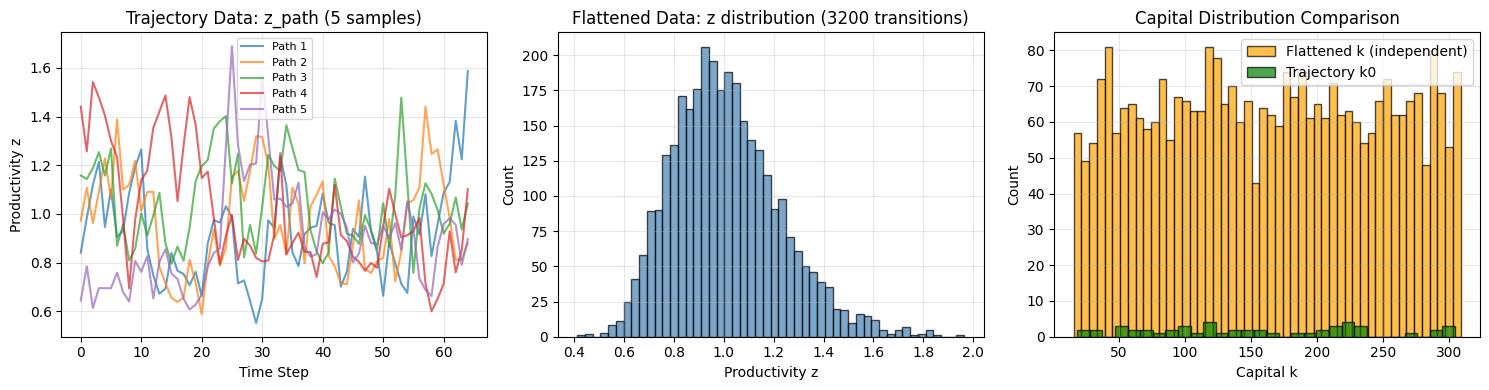


Key Observations:
  - Trajectory data: Time-dependent paths (left)
  - Flattened data: i.i.d. transitions (middle, right)
  - Independent k: Uniformly distributed across state space


In [8]:
# =============================================================================
# 1.7 Data Format Comparison (Visualization)
# =============================================================================

plot_path = os.path.join(FIGURES_DIR, "data_format_comparison.png")

# Compare data formats visually
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Trajectory z_path (first 5 paths)
z_path = traj_data['z_path'].numpy()
for i in range(min(5, z_path.shape[0])):
    axes[0].plot(z_path[i], alpha=0.7, label=f'Path {i+1}')
axes[0].set_title('Trajectory Data: z_path (5 samples)')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Productivity z')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

# Plot 2: Flattened z distribution
z_flat = flat_data['z'].numpy()
axes[1].hist(z_flat, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_title(f'Flattened Data: z distribution ({len(z_flat)} transitions)')
axes[1].set_xlabel('Productivity z')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3)

# Plot 3: Flattened k distribution (independent sampling)
k_flat = flat_data['k'].numpy()
k_traj = traj_data['k0'].numpy()
axes[2].hist(k_flat, bins=50, alpha=0.7, label='Flattened k (independent)', color='orange', edgecolor='black')
axes[2].hist(k_traj, bins=30, alpha=0.7, label='Trajectory k0', color='green', edgecolor='black')
axes[2].set_title('Capital Distribution Comparison')
axes[2].set_xlabel('Capital k')
axes[2].set_ylabel('Count')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Save and display
print(f"Saving figure to {plot_path}...")
fig.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("  - Trajectory data: Time-dependent paths (left)")
print("  - Flattened data: i.i.d. transitions (middle, right)")
print("  - Independent k: Uniformly distributed across state space")

In [9]:
# =============================================================================
# 1.8 Dataset Statistics
# =============================================================================

from src.utils.analysis import summarize_batch

# Print numerical stats of a single batch
summarize_batch(traj_data, batch_idx=0)


Batch 0 Summary:
------------------------------------------------------------
k0         shape=(50,)           mean=151.8715 std=81.2806 min=18.2754 max=304.6079
z0         shape=(50,)           mean=1.0662 std=0.3789 min=0.5444 max=1.8282
b0         shape=(50,)           mean=94.6593 std=57.0898 min=1.1634 max=188.8016
z_path     shape=(50, 65)        mean=1.0113 std=0.2174 min=0.4126 max=1.9641


---

# Section 2: Training

This section trains all models and saves checkpoints to disk.

**Note:** This section depends on Section 1 (dataset must be in memory).

## 2.1 Shared Training Configuration

Configuration shared across all scenarios (network architecture, optimization settings, etc.).

In [10]:
# =============================================================================
# 2.1.1 Shared Training Configuration
# =============================================================================

# Network Architecture (shared across all methods)
net_config = NetworkConfig(
    n_layers=2,
    n_neurons=32,    activation="swish"
)

# Optimization Settings (using config from Section 1.3)
opt_config = OptimizationConfig(
    batch_size=TRAIN_BATCH_SIZE,
    n_iter=TRAIN_N_ITER,
    learning_rate=1e-3,
    learning_rate_critic=1e-2,
    log_every=50,
    early_stopping=EarlyStoppingConfig(
        enabled=True,
        patience=5,
        eval_freq=50,
        lr_epsilon=1e-2,
        lr_window=10,
        er_epsilon=1e-2,
        br_critic_epsilon=1e-3,
        br_actor_epsilon=1e-3
    ),
    optimizer=OptimizerConfig(clipnorm=1.0)
)

# Temperature Annealing Schedule (shared)
anneal_config = AnnealingConfig(
    temperature_init=1.0,
    temperature_min=1e-6,
    decay=TRAIN_DECAY
)

# Method-specific configurations
# Using loss_type="mse" for stable, non-negative loss values
method_configs = {
    'lr': MethodConfig(name="basic_lr"),
    'er': MethodConfig(name="basic_er", polyak_tau=0.995, loss_type="mse"),
    'br': MethodConfig(name="basic_br", n_critic=10, polyak_tau=0.995, loss_type="mse")
}

print("Shared training configuration loaded.")
print(f"  Network: {net_config.n_layers} layers, {net_config.n_neurons} neurons, {net_config.activation}")
print(f"  Optimization: batch_size={opt_config.batch_size}, n_iter={opt_config.n_iter}")
print(f"  Methods: {list(method_configs.keys())}")
print(f"  Loss type: MSE (stable, non-negative)")


Shared training configuration loaded.
  Network: 2 layers, 32 neurons, swish
  Optimization: batch_size=64, n_iter=500
  Methods: ['lr', 'er', 'br']
  Loss type: MSE (stable, non-negative)


## 2.2 Baseline Training & Validation

**Train baseline (no adjustment costs) first to verify the training pipeline works.**

This section:
1. Trains all 3 methods (LR, ER, BR) on the baseline scenario only
2. Validates against the frictionless analytical solution
3. Provides quick diagnostic plots

Once baseline is working correctly, proceed to Section 2.3 for all scenarios.

In [11]:
# =============================================================================
# 2.2.1 Train Baseline Only (Quick Validation)
# =============================================================================

baseline_params = BASIC_SCENARIOS['baseline']['params']

print(f"Training BASELINE scenario only (cost_convex={baseline_params.cost_convex}, cost_fixed={baseline_params.cost_fixed})")
print(f"This should match the frictionless analytical solution.\n")

# Training functions map
train_funcs = {
    'lr': train_basic_lr,
    'er': train_basic_er,
    'br': train_basic_br
}

# Data format for each method
data_format = {
    'lr': (traj_data, val_traj),      # LR uses trajectory data
    'er': (flat_data, val_flat),       # ER uses flattened data
    'br': (flat_data, val_flat)        # BR uses flattened data
}

# Store baseline results
results_baseline = {}

for method_name, method_config in method_configs.items():
    print(f"\n{'=' * 60}")
    print(f"Training baseline/{method_name}...")
    print(f"{'=' * 60}")
    
    dataset, val_data = data_format[method_name]
    train_func = train_funcs[method_name]
    
    result = train_func(
        dataset=dataset,
        net_config=net_config,
        opt_config=opt_config,
        method_config=method_config,
        anneal_config=anneal_config,
        params=baseline_params,
        shock_params=shock_params,
        bounds=bounds,
        validation_data=val_data
    )
    
    results_baseline[method_name] = result
    
    # Print final loss
    if method_name == 'lr':
        print(f"  Final LR loss: {result['history']['loss_LR'][-1]:.6f}")
    elif method_name == 'er':
        print(f"  Final ER loss: {result['history']['loss_ER'][-1]:.6f}")
    else:  # br
        print(f"  Final BR critic loss: {result['history']['loss_critic'][-1]:.6f}")

print(f"\n{'=' * 60}")
print(f"BASELINE TRAINING COMPLETE")
print(f"{'=' * 60}")

Training BASELINE scenario only (cost_convex=0.0, cost_fixed=0.0)
This should match the frictionless analytical solution.


Training baseline/lr...
[INFO] core: Starting Training Loop: Method=basic_lr, Iterations=500, EarlyStopping=enabled
[INFO] core: Dataset format validation passed for LR method
[INFO] core: Convergence checker created. N_anneal=1719, Patience=5
[INFO] core: Iter 50: loss_LR=-317.2183 Temp (log10)=-0.21
[INFO] core: Iter 100: loss_LR=-328.7275 Temp (log10)=-0.43
[INFO] core: Iter 150: loss_LR=-334.4291 Temp (log10)=-0.65
[INFO] core: Iter 200: loss_LR=-340.1762 Temp (log10)=-0.87
[INFO] core: Iter 250: loss_LR=-343.8745 Temp (log10)=-1.09
[INFO] core: Iter 300: loss_LR=-344.1481 Temp (log10)=-1.31
[INFO] core: Iter 350: loss_LR=-344.1516 Temp (log10)=-1.52
[INFO] core: Iter 400: loss_LR=-344.1539 Temp (log10)=-1.74
[INFO] core: Iter 450: loss_LR=-344.1560 Temp (log10)=-1.96
[INFO] core: Iter 500: loss_LR=-344.1579 Temp (log10)=-2.18
[INFO] core: Training finished in

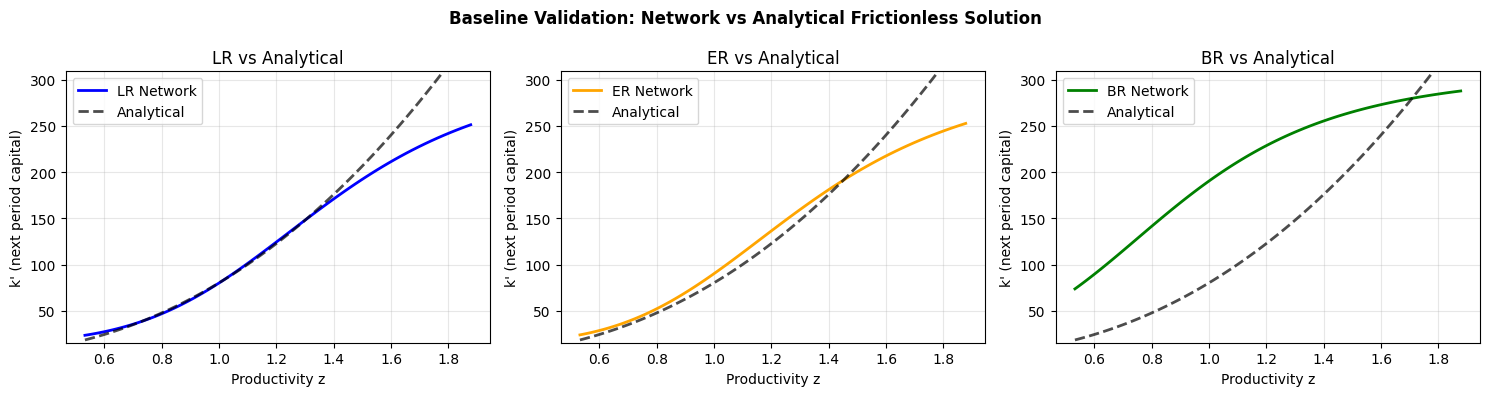


Note: All values are in LEVELS (k_bounds = (15.447022976557044, 308.94045953114085))
Fixed k at k* = 77.24

If networks match the analytical solution (dashed line), training is working!


In [12]:
# =============================================================================
# 2.2.2 Quick Baseline Validation (Compare to Analytical Solution)
# =============================================================================

from src.utils.analysis import evaluate_policy, compute_frictionless_policy
import matplotlib.pyplot as plt

# Evaluate baseline policies
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
method_names = ['lr', 'er', 'br']
colors = ['blue', 'orange', 'green']

# Create z values for plotting
z_plot = np.exp(np.linspace(logz_bounds[0], logz_bounds[1], 100))

# Compute frictionless (analytical) policy in LEVELS
# Note: Network outputs are in levels, so frictionless must also be in levels
k_frictionless = compute_frictionless_policy(z_plot, baseline_params, shock_params)

# Use k* (steady state capital) from bounds as reference point
k_star = bounds.get('k_star', (k_bounds[0] + k_bounds[1]) / 2)

for idx, method_name in enumerate(method_names):
    ax = axes[idx]
    result = results_baseline[method_name]
    
    # Evaluate policy at k=k* (steady state capital in LEVELS)
    grid = evaluate_policy(result, k_bounds=k_bounds, logz_bounds=logz_bounds, 
                          fixed_k_val=k_star, n_k=50, n_z=100)
    
    # Get k'(z) slice at fixed k
    k_idx = grid['fixed_k_idx']
    z_vals = grid['z'][k_idx, :]
    k_next_vals = grid['k_next'][k_idx, :]
    
    # Plot - both network and analytical are now in LEVELS
    ax.plot(z_vals, k_next_vals, color=colors[idx], linewidth=2, label=f'{method_name.upper()} Network')
    ax.plot(z_plot, k_frictionless, 'k--', linewidth=2, alpha=0.7, label='Analytical')
    ax.set_xlabel('Productivity z')
    ax.set_ylabel("k' (next period capital)")
    ax.set_title(f'{method_name.upper()} vs Analytical')
    ax.legend()
    ax.grid(True, alpha=0.3)
    # Use k_bounds for y-axis limits (values are in LEVELS)
    ax.set_ylim([k_bounds[0], k_bounds[1]])

fig.suptitle('Baseline Validation: Network vs Analytical Frictionless Solution', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'baseline_validation.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nNote: All values are in LEVELS (k_bounds = {k_bounds})")
print(f"Fixed k at k* = {k_star:.2f}")
print("\nIf networks match the analytical solution (dashed line), training is working!")

## 2.3 All Scenarios Training Loop (Optional)

**Skip this section if you only want to validate baseline.**

This runs the full training loop for all scenarios. Only run after baseline is validated.

In [13]:
# =============================================================================
# 2.3.1 Train All Basic Model Scenarios
# =============================================================================

# Store all results: results_basic[scenario_name][method_name] = result_dict
# Initialize with baseline results from Section 2.2
results_basic = {
    'baseline': results_baseline  # Reuse baseline from 2.2
}

# Training functions map
train_funcs = {
    'lr': train_basic_lr,
    'er': train_basic_er,
    'br': train_basic_br
}

# Data format for each method
data_format = {
    'lr': (traj_data, val_traj),      # LR uses trajectory data
    'er': (flat_data, val_flat),       # ER uses flattened data
    'br': (flat_data, val_flat)        # BR uses flattened data
}

# Only train non-baseline scenarios (baseline already done in 2.2)
scenarios_to_train = {k: v for k, v in BASIC_SCENARIOS.items() if k != 'baseline'}

total_runs = len(scenarios_to_train) * len(method_configs)
run_count = 0

print(f"Training {len(scenarios_to_train)} additional scenarios (baseline already trained in 2.2)")

for scenario_name, scenario in scenarios_to_train.items():
    print(f"\n{'=' * 70}")
    print(f"# SCENARIO: {scenario_name}")
    print(f"# {scenario['description']}")
    print(f"# cost_convex={scenario['params'].cost_convex}, cost_fixed={scenario['params'].cost_fixed}")
    print(f"{'=' * 70}")
    
    results_basic[scenario_name] = {}
    
    for method_name, method_config in method_configs.items():
        run_count += 1
        print(f"\n[{run_count}/{total_runs}] Training {scenario_name}/{method_name}...")
        
        dataset, val_data = data_format[method_name]
        train_func = train_funcs[method_name]
        
        result = train_func(
            dataset=dataset,
            net_config=net_config,
            opt_config=opt_config,
            method_config=method_config,
            anneal_config=anneal_config,
            params=scenario['params'],
            shock_params=shock_params,
            bounds=bounds,
            validation_data=val_data
        )
        
        results_basic[scenario_name][method_name] = result
        
        # Print final loss
        if method_name == 'lr':
            print(f"  Final LR loss: {result['history']['loss_LR'][-1]:.6f}")
        elif method_name == 'er':
            print(f"  Final ER loss: {result['history']['loss_ER'][-1]:.6f}")
        else:  # br
            print(f"  Final BR critic loss: {result['history']['loss_critic'][-1]:.6f}")

print(f"\n{'=' * 70}")
print(f"BASIC MODEL TRAINING COMPLETE: {total_runs + 3} runs (3 baseline + {total_runs} others)")
print(f"{'=' * 70}")
for scenario_name in results_basic:
    print(f"  {scenario_name}: {list(results_basic[scenario_name].keys())}")

Training 2 additional scenarios (baseline already trained in 2.2)

# SCENARIO: smooth_cost
# Convex adjustment costs only
# cost_convex=0.2, cost_fixed=0.0

[1/6] Training smooth_cost/lr...
[INFO] core: Starting Training Loop: Method=basic_lr, Iterations=500, EarlyStopping=enabled
[INFO] core: Dataset format validation passed for LR method
[INFO] core: Convergence checker created. N_anneal=1719, Patience=5
[INFO] core: Iter 50: loss_LR=-310.5242 Temp (log10)=-0.21
[INFO] core: Iter 100: loss_LR=-318.6380 Temp (log10)=-0.43
[INFO] core: Iter 150: loss_LR=-324.5526 Temp (log10)=-0.65
[INFO] core: Iter 200: loss_LR=-329.1244 Temp (log10)=-0.87
[INFO] core: Iter 250: loss_LR=-329.6845 Temp (log10)=-1.09
[INFO] core: Iter 300: loss_LR=-329.7513 Temp (log10)=-1.31
[INFO] core: Iter 350: loss_LR=-329.8156 Temp (log10)=-1.52
[INFO] core: Iter 400: loss_LR=-329.8830 Temp (log10)=-1.74
[INFO] core: Iter 450: loss_LR=-329.9580 Temp (log10)=-1.96
[INFO] core: Iter 500: loss_LR=-330.0451 Temp (log1

## 2.4 Risky Debt Model Training

Single baseline scenario with BR method only.

In [14]:
# =============================================================================
# 2.4.1 Risky Debt Configuration and Training
# =============================================================================

# Store risky results: results_risky[scenario_name] = result_dict
results_risky = {}

# Risky-specific method config with MSE loss for stability
method_config_risky = MethodConfig(
    name="risky_br",
    n_critic=10,
    polyak_tau=0.995,
    loss_type="mse",  # MSE for stable training (vs "crossprod" which can be negative)
    risky=RiskyDebtConfig(
        weight_br=0.1,
        loss_type="mse"  # MSE for price loss as well
    )
)

# Risky-specific annealing (tighter logit_clip)
anneal_config_risky = AnnealingConfig(
    temperature_init=1.0,
    temperature_min=1e-4,
    decay=0.995,  # Use profile config
    logit_clip=5.0
)


# Risky-specific optimization (uses profile config)
opt_config_risky = OptimizationConfig(
    batch_size=TRAIN_RISKY_BATCH_SIZE,
    n_iter=TRAIN_RISKY_N_ITER,
    learning_rate=1e-4,
    learning_rate_critic=1e-3,
    log_every=50,
    early_stopping=EarlyStoppingConfig(
        enabled=True,
        patience=5,
        eval_freq=50,
        br_critic_epsilon=1e-5,
        br_actor_epsilon=1e-4
    ),
    optimizer=OptimizerConfig(clipnorm=1.0)
)

# Loop over economic scenarios for risky debt
for scenario_name, scenario in RISKY_SCENARIOS.items():
    print(f"\n{'#' * 70}")
    print(f"# RISKY DEBT SCENARIO: {scenario_name}")
    print(f"# {scenario['description']}")
    print(f"{'#' * 70}")
    
    print(f"\nTraining Risky Debt BR Method...")
    result = train_risky_br(
        dataset=flat_data,
        net_config=net_config,
        opt_config=opt_config_risky,
        method_config=method_config_risky,
        anneal_config=anneal_config_risky,
        params=scenario['params'],
        shock_params=shock_params,
        bounds=bounds
    )
    
    results_risky[scenario_name] = result
    
    print(f"\n  Final critic loss: {result['history']['loss_critic'][-1]:.6f}")
    print(f"  Final actor loss:  {result['history']['loss_actor'][-1]:.6f}")
    print(f"  Final price loss:  {result['history']['loss_price'][-1]:.6f}")

print(f"\n{'=' * 70}")
print(f"RISKY DEBT TRAINING COMPLETE: {len(results_risky)} scenarios")
print(f"{'=' * 70}")



######################################################################
# RISKY DEBT SCENARIO: baseline
# Standard risky debt with all cost components
######################################################################

Training Risky Debt BR Method...
[INFO] risky: RiskyDebtTrainerBR initialized: weight_br=0.10, n_critic=10, polyak_tau=0.995, loss_type=mse
[INFO] core: Starting Training Loop: Method=risky_br, Iterations=500, EarlyStopping=enabled
[INFO] core: Dataset format validation passed for BR method
[INFO] core: Convergence checker created. N_anneal=2297, Patience=5
[INFO] core: Iter 50: actor=-0.2834 critic=2463.8718 price=3.1016 Temp (log10)=-0.11
[INFO] core: Iter 100: actor=2.9573 critic=5.2849 price=3.2212 Temp (log10)=-0.22
[INFO] core: Iter 150: actor=-9.2700 critic=2.3015 price=2.0873 Temp (log10)=-0.32
[INFO] core: Iter 200: actor=-15.9754 critic=5.6603 price=3.1227 Temp (log10)=-0.43
[INFO] core: Iter 250: actor=-19.3828 critic=9.5468 price=8.0073 Temp (log10)=-0.54

In [15]:
# =============================================================================
# 2.4.2 Risky Debt Training Diagnostics
# =============================================================================

from src.utils.analysis import print_training_summary

# Print summary table first
print_training_summary(results_risky, model_type="risky")

# Plot training diagnostics for risky debt (2x3 panel)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
colors = plt.cm.tab10.colors

for idx, (scenario_name, result) in enumerate(results_risky.items()):
    color = colors[idx % len(colors)]
    history = result['history']
    iters = history.get('iteration', list(range(len(history['loss_actor']))))
    
    # Row 1: Loss curves
    axes[0, 0].plot(iters, history.get('rel_mse', history['loss_critic']), 
                    label=scenario_name, color=color, alpha=0.8)
    axes[0, 1].plot(iters, history['loss_actor'], label=scenario_name, color=color, alpha=0.8)
    axes[0, 2].plot(iters, history['loss_price'], label=scenario_name, color=color, alpha=0.8)
    
    # Row 2: Scale and constraint diagnostics
    if 'mean_value_scale' in history:
        axes[1, 0].plot(iters, history['mean_value_scale'], label=scenario_name, color=color, alpha=0.8)
    if 'frac_b_at_limit' in history:
        axes[1, 1].plot(iters, history['frac_b_at_limit'], label=scenario_name, color=color, alpha=0.8)
    if 'frac_default_hard' in history:
        axes[1, 2].plot(iters, history['frac_default_hard'], label=f'{scenario_name} (hard)', 
                       color=color, alpha=0.8)
    if 'mean_p_default' in history:
        axes[1, 2].plot(iters, history['mean_p_default'], label=f'{scenario_name} (soft)', 
                       color=color, linestyle='--', alpha=0.8)

# Configure panels
panel_config = [
    (axes[0, 0], 'Relative MSE (Critic)', 'Rel MSE'),
    (axes[0, 1], 'Actor Loss', 'Loss'),
    (axes[0, 2], 'Price Loss', 'Loss'),
    (axes[1, 0], 'Value Scale Growth', 'Mean |V|'),
    (axes[1, 1], 'Debt Constraint Binding', 'Fraction'),
    (axes[1, 2], 'Default Rates', 'Rate'),
]
for ax, title, ylabel in panel_config:
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Iteration')
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

axes[1, 1].set_ylim([0, 1])
axes[1, 2].set_ylim([0, 1])

fig.suptitle('Risky Debt BR Training Diagnostics', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'risky_debt_diagnostics.png'), dpi=150, bbox_inches='tight')
plt.show()


## 2.5 Save Checkpoints

Save all training results with hierarchical structure inside `results/part1-demo/`.

In [16]:
# =============================================================================
# 2.4.1 Save All Training Results with Hierarchical Structure
# =============================================================================

import json
import dataclasses
from src.utils.checkpointing import save_training_result

# Save basic model results: checkpoints/basic/{scenario}/{method}
print("=" * 70)
print("SAVING BASIC MODEL RESULTS")
print("=" * 70)

basic_dir = os.path.join(CHECKPOINTS_DIR, "basic")
for scenario_name, scenario_results in results_basic.items():
    scenario_dir = os.path.join(basic_dir, scenario_name)
    print(f"\nScenario: {scenario_name}")
    
    for method_name, result in scenario_results.items():
        save_training_result(
            result=result,
            save_dir=scenario_dir,
            name=method_name,
            overwrite=True,
            verbose=False
        )
        print(f"  Saved {method_name} -> {scenario_dir}/{method_name}/")
    
    # Save scenario-specific params alongside the checkpoint
    scenario_params = BASIC_SCENARIOS[scenario_name]['params']
    params_to_save = {
        'params': dataclasses.asdict(scenario_params),
        'shock_params': dataclasses.asdict(shock_params)
    }
    params_path = os.path.join(scenario_dir, 'params.json')
    with open(params_path, 'w') as f:
        json.dump(params_to_save, f, indent=2)
    print(f"  Saved params -> {params_path}")

# Save risky model results: checkpoints/risky/{scenario}
print("\n" + "=" * 70)
print("SAVING RISKY DEBT RESULTS")
print("=" * 70)

risky_dir = os.path.join(CHECKPOINTS_DIR, "risky")
for scenario_name, result in results_risky.items():
    scenario_dir = os.path.join(risky_dir, scenario_name)
    save_training_result(
        result=result,
        save_dir=risky_dir,
        name=scenario_name,
        overwrite=True,
        verbose=False
    )
    print(f"  Saved {scenario_name} -> {risky_dir}/{scenario_name}/")
    
    # Save scenario-specific params alongside the checkpoint
    scenario_params = RISKY_SCENARIOS[scenario_name]['params']
    params_to_save = {
        'params': dataclasses.asdict(scenario_params),
        'shock_params': dataclasses.asdict(shock_params)
    }
    # For risky, the checkpoint is saved as risky/{scenario_name}/, so put params.json there
    params_path = os.path.join(risky_dir, scenario_name, 'params.json')
    with open(params_path, 'w') as f:
        json.dump(params_to_save, f, indent=2)
    print(f"  Saved params -> {params_path}")

# Save scenario definitions for Section 3
scenarios_meta = {
    'basic_scenarios': list(BASIC_SCENARIOS.keys()),
    'risky_scenarios': list(RISKY_SCENARIOS.keys()),
    'methods': list(method_configs.keys())
}

meta_path = os.path.join(CHECKPOINTS_DIR, 'scenarios.json')
with open(meta_path, 'w') as f:
    json.dump(scenarios_meta, f, indent=2)

print(f"\nScenario metadata saved to {meta_path}")
print("\n" + "=" * 70)
print("ALL CHECKPOINTS SAVED")
print("=" * 70)

SAVING BASIC MODEL RESULTS

Scenario: baseline
  Saved lr -> ../results/part1-demo/checkpoints/basic/baseline/lr/
  Saved er -> ../results/part1-demo/checkpoints/basic/baseline/er/
  Saved br -> ../results/part1-demo/checkpoints/basic/baseline/br/
  Saved params -> ../results/part1-demo/checkpoints/basic/baseline/params.json

Scenario: smooth_cost
  Saved lr -> ../results/part1-demo/checkpoints/basic/smooth_cost/lr/
  Saved er -> ../results/part1-demo/checkpoints/basic/smooth_cost/er/
  Saved br -> ../results/part1-demo/checkpoints/basic/smooth_cost/br/
  Saved params -> ../results/part1-demo/checkpoints/basic/smooth_cost/params.json

Scenario: fixed_cost
  Saved lr -> ../results/part1-demo/checkpoints/basic/fixed_cost/lr/
  Saved er -> ../results/part1-demo/checkpoints/basic/fixed_cost/er/
  Saved br -> ../results/part1-demo/checkpoints/basic/fixed_cost/br/
  Saved params -> ../results/part1-demo/checkpoints/basic/fixed_cost/params.json

SAVING RISKY DEBT RESULTS
  Saved baseline -> .

In [17]:
# =============================================================================
# 2.4.2 Save Bounds (needed for policy evaluation in Section 3)
# =============================================================================

import json

bounds_to_save = {
    'k': list(bounds['k']),
    'log_z': list(bounds['log_z']),
    'b': list(bounds['b'])
}

bounds_path = os.path.join(CHECKPOINTS_DIR, 'bounds.json')
with open(bounds_path, 'w') as f:
    json.dump(bounds_to_save, f, indent=2)

print(f"Bounds saved to {bounds_path}")
print("\nSection 2 complete. You can now restart the kernel and run Section 3 independently.")

Bounds saved to ../results/part1-demo/checkpoints/bounds.json

Section 2 complete. You can now restart the kernel and run Section 3 independently.


---

# Section 3: Analysis & Visualization

This section is **fully independent** - it loads checkpoints from disk and can run after a kernel restart.

Example Usage:
1. Run Section 1-2 once and save checkpoints
2. Restart kernel
3. Run only the cells in Section 3 and experiment with visualizations, etc.

In [18]:
# =============================================================================
# 3.1 Imports and Setup (for independent execution)
# =============================================================================

import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Add project root to path
sys.path.append(os.path.abspath(".."))

# Run configuration
RUN_NAME = "part1-demo"
RESULTS_DIR = os.path.join("..", "results", RUN_NAME)
FIGURES_DIR = os.path.join(RESULTS_DIR, "figures")
CHECKPOINTS_DIR = os.path.join(RESULTS_DIR, "checkpoints")

print(f"Loading results from: {RESULTS_DIR}")

Loading results from: ../results/part1-demo


In [19]:
# =============================================================================
# 3.2 Load Scenario Metadata and Checkpoints
# =============================================================================

from src.utils.checkpointing import load_training_result

# Load scenario metadata
scenarios_path = os.path.join(CHECKPOINTS_DIR, 'scenarios.json')
with open(scenarios_path, 'r') as f:
    scenarios_meta = json.load(f)

basic_scenarios = scenarios_meta['basic_scenarios']
risky_scenarios = scenarios_meta['risky_scenarios']
methods = scenarios_meta['methods']

print(f"Scenarios loaded:")
print(f"  Basic: {basic_scenarios}")
print(f"  Risky: {risky_scenarios}")
print(f"  Methods: {methods}")

# Load all basic model results
print("\n" + "=" * 70)
print("LOADING BASIC MODEL RESULTS")
print("=" * 70)

results_basic = {}
for scenario_name in basic_scenarios:
    results_basic[scenario_name] = {}
    print(f"\nScenario: {scenario_name}")
    
    for method_name in methods:
        checkpoint_dir = os.path.join(CHECKPOINTS_DIR, "basic", scenario_name, method_name)
        result = load_training_result(checkpoint_dir, verbose=False)
        results_basic[scenario_name][method_name] = result
        print(f"  Loaded {method_name}")

# Load risky model results
print("\n" + "=" * 70)
print("LOADING RISKY DEBT RESULTS")
print("=" * 70)

results_risky = {}
for scenario_name in risky_scenarios:
    checkpoint_dir = os.path.join(CHECKPOINTS_DIR, "risky", scenario_name)
    result = load_training_result(checkpoint_dir, verbose=False)
    results_risky[scenario_name] = result
    print(f"  Loaded {scenario_name}")

print(f"\nLoaded {len(basic_scenarios) * len(methods)} basic + {len(risky_scenarios)} risky results.")

Scenarios loaded:
  Basic: ['baseline', 'smooth_cost', 'fixed_cost']
  Risky: ['baseline']
  Methods: ['lr', 'er', 'br']

LOADING BASIC MODEL RESULTS

Scenario: baseline
  Loaded lr
  Loaded er
  Loaded br

Scenario: smooth_cost
  Loaded lr
  Loaded er
  Loaded br

Scenario: fixed_cost
  Loaded lr
  Loaded er
  Loaded br

LOADING RISKY DEBT RESULTS
  Loaded baseline

Loaded 9 basic + 1 risky results.


In [20]:
# =============================================================================
# 3.3 Load Bounds (for policy evaluation)
# =============================================================================

bounds_path = os.path.join(CHECKPOINTS_DIR, 'bounds.json')
with open(bounds_path, 'r') as f:
    bounds_loaded = json.load(f)

k_bounds = tuple(bounds_loaded['k'])
logz_bounds = tuple(bounds_loaded['log_z'])
b_bounds = tuple(bounds_loaded['b'])

print(f"Bounds loaded: k={k_bounds}, log_z={logz_bounds}, b={b_bounds}")

Bounds loaded: k=(15.447022976557044, 308.94045953114085), log_z=(-0.6301260378126043, 0.6301260378126043), b=(0.0, 188.9954691887226)


## 3.4 Basic Model Analysis

Analyze training results across scenarios and methods:
- **Per-scenario**: Compare LR, ER, BR methods within each scenario
- **Cross-scenario**: Compare the same method across different cost structures

In [21]:
# =============================================================================
# 3.4.1 Per-Scenario Loss Curves (6-panel format)
# =============================================================================

from src.utils.plotting import plot_basic_loss_curves

for scenario_name in basic_scenarios:
    scenario_results = results_basic[scenario_name]
    
    fig = plot_basic_loss_curves(
        result_lr=scenario_results['lr'],
        result_er=scenario_results['er'],
        result_br=scenario_results['br'],
        scenario_name=scenario_name,
        save_path=f"basic_loss_curves_{scenario_name}.png"
    )
    plt.show()
    print(f"Saved: basic_loss_curves_{scenario_name}.png")


In [22]:
# =============================================================================
# 3.4.2 Cross-Scenario Summary Table
# =============================================================================

from src.utils.analysis import print_training_summary

# Clean summary table using utility function
print_training_summary(results_basic, model_type="basic")

# Build detailed summary with pandas for additional analysis
summary_data = []
for scenario_name in basic_scenarios:
    scenario_results = results_basic[scenario_name]
    
    for method_name in methods:
        result = scenario_results[method_name]
        
        # Get final loss based on method
        if method_name == 'lr':
            final_loss = result['history']['loss_LR'][-1]
            loss_name = 'LR Loss'
        elif method_name == 'er':
            final_loss = result['history']['loss_ER'][-1]
            loss_name = 'ER Loss'
        else:  # br
            # Use rel_mse for BR as it's more meaningful
            final_loss = result['history'].get('rel_mse', result['history']['loss_critic'])[-1]
            loss_name = 'BR RelMSE'
        
        summary_data.append({
            'Scenario': scenario_name,
            'Method': method_name.upper(),
            'Final Loss': final_loss,
            'Loss Type': loss_name
        })

summary_df = pd.DataFrame(summary_data)

# Pivot table for easier comparison
pivot_df = summary_df.pivot(index='Scenario', columns='Method', values='Final Loss')

print("\nPivot Table (Final Losses):")
print(pivot_df.to_string())



Scenario: baseline
Loaded params: cost_convex=0.0, cost_fixed=0.0
Steady State Capital (k*):
  LR: 80.3610
  ER: 90.4030
  BR: 168.7404


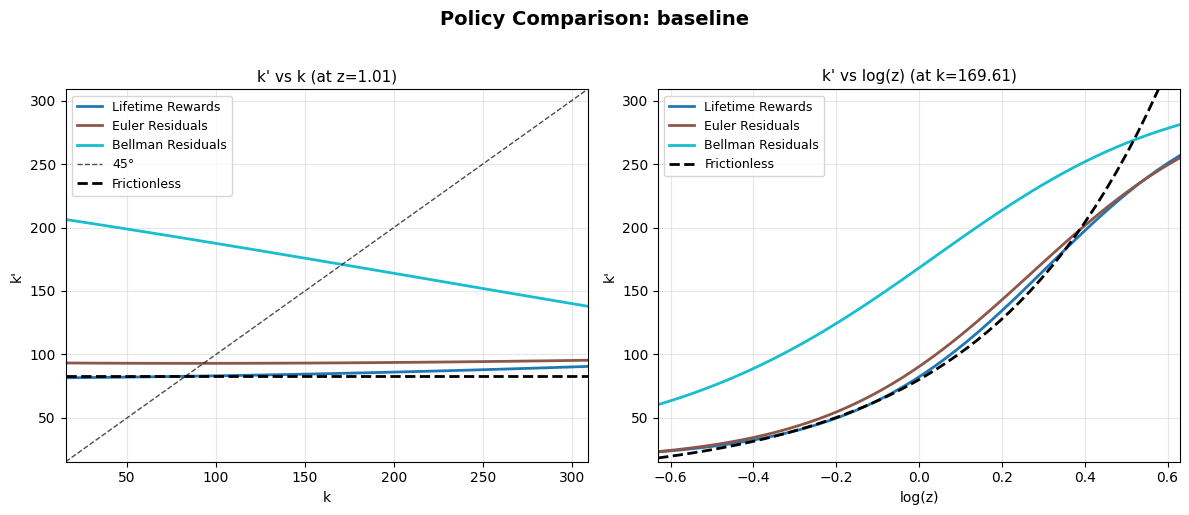


Scenario: smooth_cost
Loaded params: cost_convex=0.2, cost_fixed=0.0
Steady State Capital (k*):
  LR: 74.6434
  ER: 85.0989
  BR: 62.4150


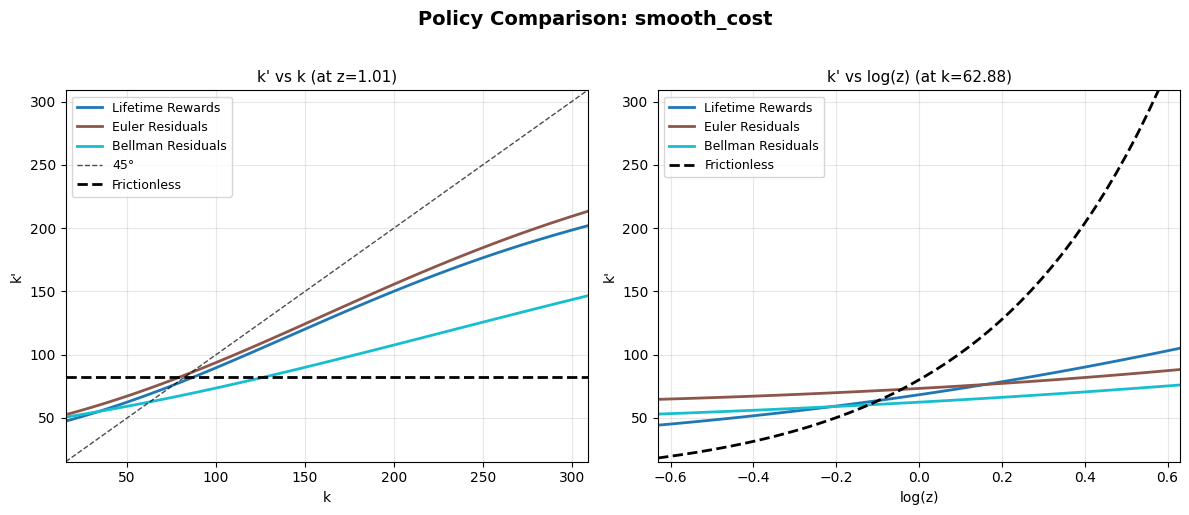


Scenario: fixed_cost
Loaded params: cost_convex=0.0, cost_fixed=0.05
Steady State Capital (k*):
  LR: 35.9963
  ER: 85.2474
  BR: 15.5970


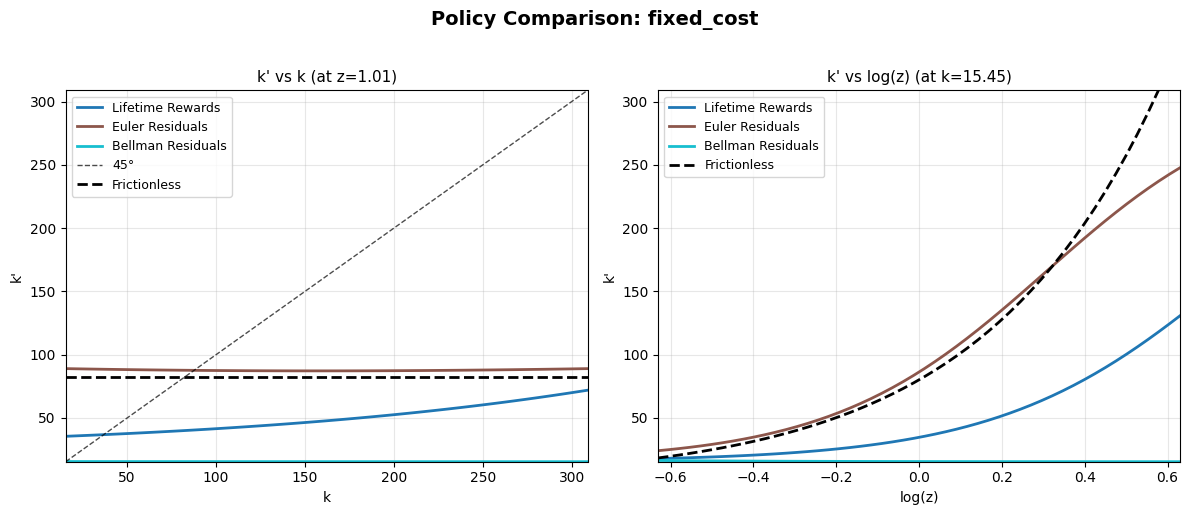

In [23]:
# =============================================================================
# 3.4.3 Per-Scenario Policy Comparison (LR vs ER vs BR)
# =============================================================================

from src.utils.analysis import get_steady_state_policy, evaluate_policy
from src.utils.plotting import plot_policy_comparison_panels
from src.economy.parameters import EconomicParams, ShockParams

n_scenarios = len(basic_scenarios)

for scenario_name in basic_scenarios:
    print(f"\n{'=' * 60}")
    print(f"Scenario: {scenario_name}")
    print(f"{'=' * 60}")
    
    scenario_results = results_basic[scenario_name]
    
    # Load params that were used during training for this scenario
    params_path = os.path.join(CHECKPOINTS_DIR, "basic", scenario_name, 'params.json')
    with open(params_path, 'r') as f:
        saved_params = json.load(f)
    
    scenario_params = EconomicParams(**saved_params['params'])
    scenario_shock_params = ShockParams(**saved_params['shock_params'])
    
    print(f"Loaded params: cost_convex={scenario_params.cost_convex}, cost_fixed={scenario_params.cost_fixed}")
    
    # Find steady states
    ss_lr = get_steady_state_policy(scenario_results['lr'], k_bounds=k_bounds, logz_bounds=logz_bounds)
    ss_er = get_steady_state_policy(scenario_results['er'], k_bounds=k_bounds, logz_bounds=logz_bounds)
    ss_br = get_steady_state_policy(scenario_results['br'], k_bounds=k_bounds, logz_bounds=logz_bounds)
    
    print(f"Steady State Capital (k*):")
    print(f"  LR: {ss_lr['k_star_val']:.4f}")
    print(f"  ER: {ss_er['k_star_val']:.4f}")
    print(f"  BR: {ss_br['k_star_val']:.4f}")
    
    # Evaluate policies (use BR's steady state as reference)
    grid_lr = evaluate_policy(scenario_results['lr'], k_bounds=k_bounds, logz_bounds=logz_bounds,
                              fixed_k_val=ss_br['k_star_val'])
    grid_er = evaluate_policy(scenario_results['er'], k_bounds=k_bounds, logz_bounds=logz_bounds,
                              fixed_k_val=ss_br['k_star_val'])
    grid_br = evaluate_policy(scenario_results['br'], k_bounds=k_bounds, logz_bounds=logz_bounds,
                              fixed_k_val=ss_br['k_star_val'])
    
    # Add frictionless benchmark using the scenario's actual params
    benchmark = {'params': scenario_params, 'shock_params': scenario_shock_params}
    
    # Comparison plot
    fig = plot_policy_comparison_panels(
        [grid_lr, grid_er, grid_br],
        labels=['Lifetime Rewards', 'Euler Residuals', 'Bellman Residuals'],
        suptitle=f"Policy Comparison: {scenario_name}",
        frictionless_benchmark=benchmark
    )
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f"basic_policy_comparison_{scenario_name}.png"), 
                dpi=150, bbox_inches='tight')
    plt.show()

Depreciation rate (delta): 0.15

Generating cross-scenario comparison plots for each method...

Method: LR
  baseline: k* = 80.3610
  smooth_cost: k* = 74.6434
  fixed_cost: k* = 35.9963


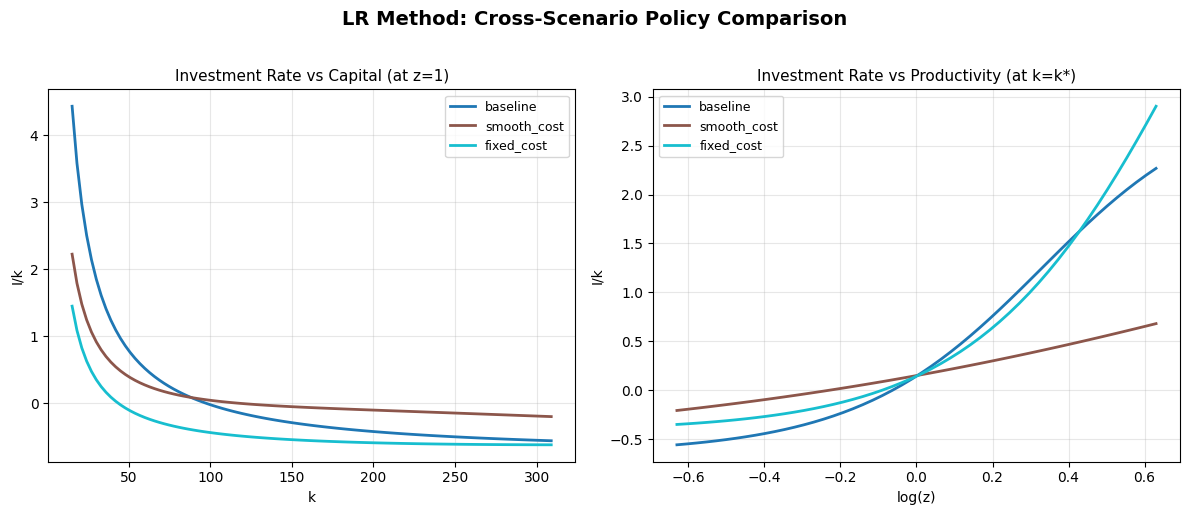

  Saved: basic_scenario_comparison_lr.png

Method: ER
  baseline: k* = 90.4030
  smooth_cost: k* = 85.0989
  fixed_cost: k* = 85.2474


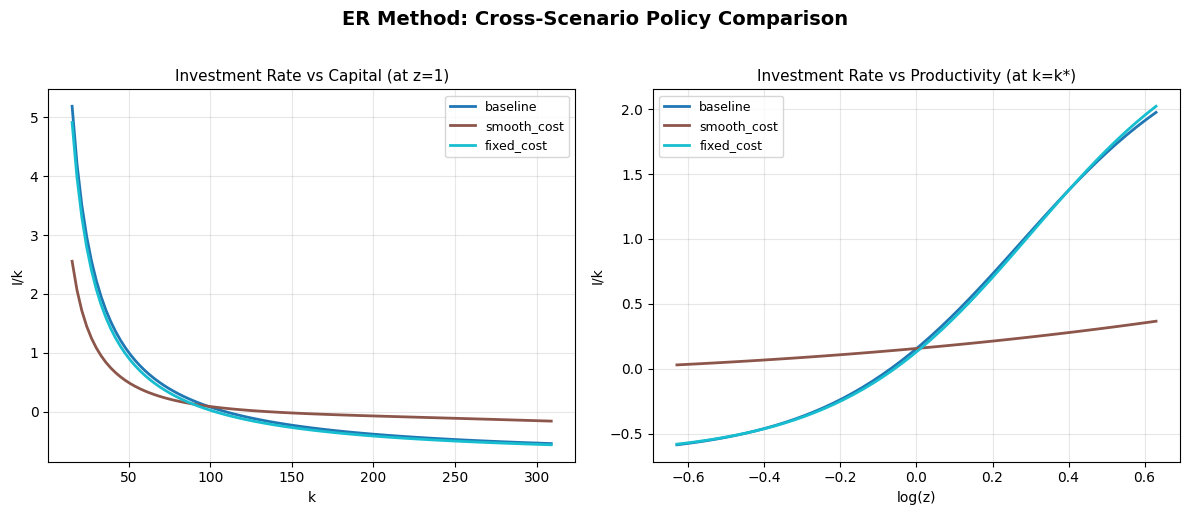

  Saved: basic_scenario_comparison_er.png

Method: BR
  baseline: k* = 168.7404
  smooth_cost: k* = 62.4150
  fixed_cost: k* = 15.5970


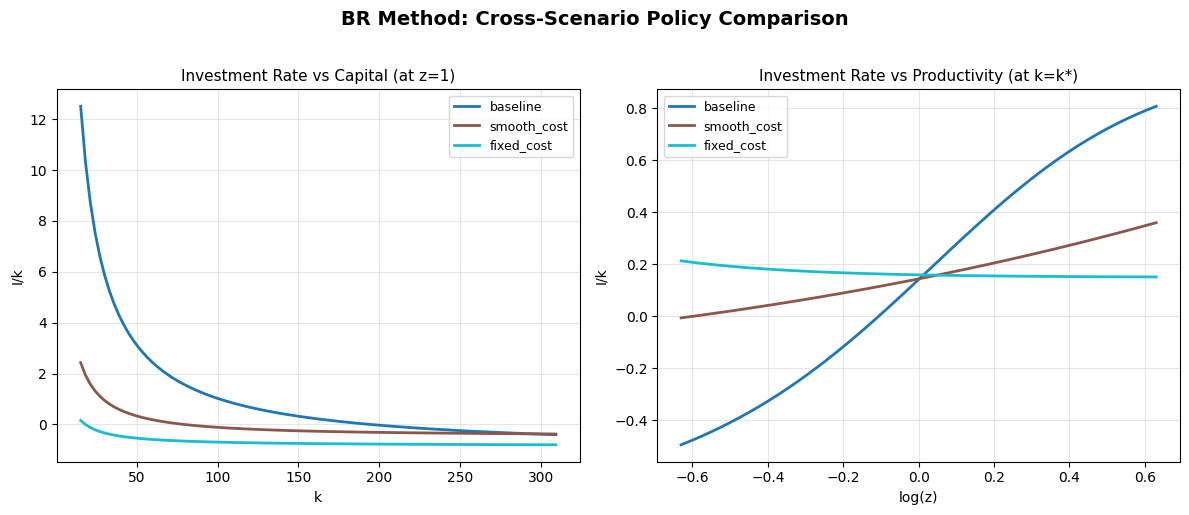

  Saved: basic_scenario_comparison_br.png

Cross-scenario comparison plots complete!


In [24]:
# =============================================================================
# 3.4.4 Cross-Scenario Policy Comparison (I/k and b'/k Transformations)
# =============================================================================
# Compare transformed policies across scenarios for each training method.
# - Investment rate: I/k = k'/k - (1-δ)
# - Leverage ratio: b'/k (risky model only)

from src.utils.plotting import plot_scenario_comparison_panels
from src.economy.parameters import EconomicParams

# Get delta from economic parameters (same across all scenarios)
# Use default EconomicParams since delta is consistent across all scenarios
delta = EconomicParams().delta

print(f"Depreciation rate (delta): {delta}")
print(f"\nGenerating cross-scenario comparison plots for each method...")

for method_name in methods:
    print(f"\n{'=' * 60}")
    print(f"Method: {method_name.upper()}")
    print(f"{'=' * 60}")
    
    # Collect eval_datas for all scenarios
    scenario_eval_datas = {}
    
    for scenario_name in basic_scenarios:
        scenario_results = results_basic[scenario_name]
        result = scenario_results[method_name]
        
        # Find steady state for this scenario/method combination
        ss = get_steady_state_policy(result, k_bounds=k_bounds, logz_bounds=logz_bounds)
        
        # Evaluate policy at its own steady state
        grid = evaluate_policy(
            result, 
            k_bounds=k_bounds, 
            logz_bounds=logz_bounds,
            fixed_k_val=ss['k_star_val']
        )
        
        scenario_eval_datas[scenario_name] = grid
        print(f"  {scenario_name}: k* = {ss['k_star_val']:.4f}")
    
    # Create cross-scenario comparison plot
    fig = plot_scenario_comparison_panels(
        scenario_eval_datas,
        delta=delta,
        suptitle=f"{method_name.upper()} Method: Cross-Scenario Policy Comparison"
    )
    
    # Save figure
    save_path = os.path.join(FIGURES_DIR, f"basic_scenario_comparison_{method_name}.png")
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"  Saved: {os.path.basename(save_path)}")

print(f"\n{'=' * 60}")
print("Cross-scenario comparison plots complete!")
print(f"{'=' * 60}")

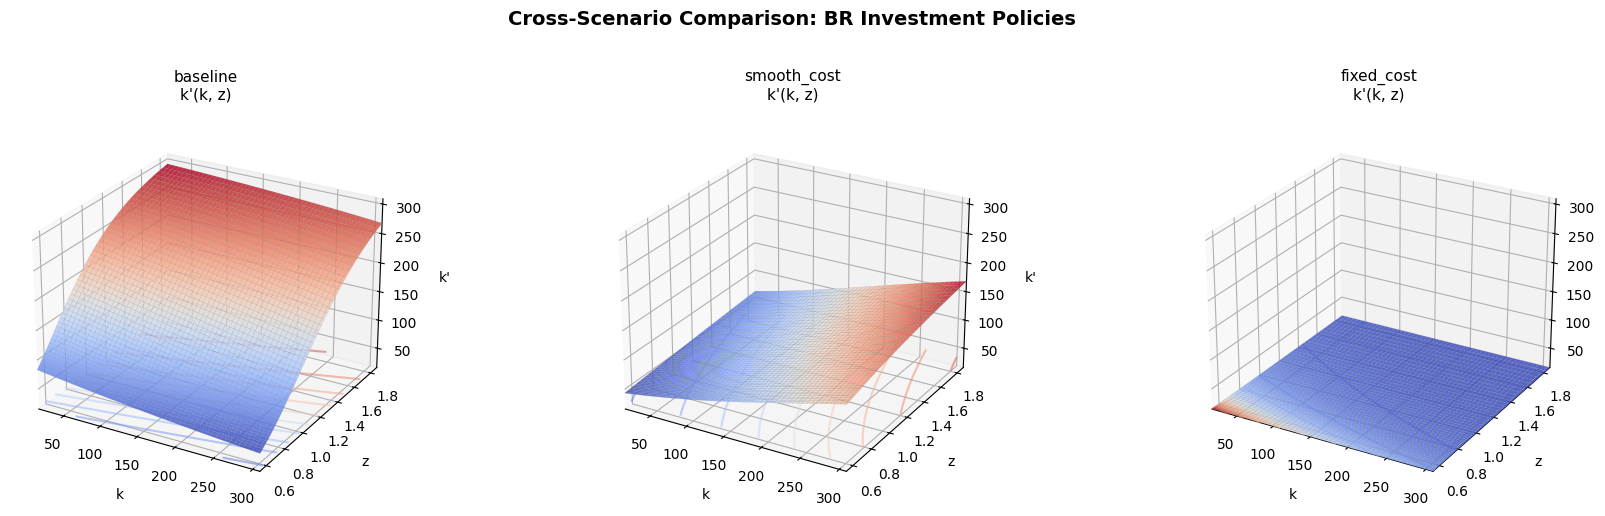

In [25]:
# =============================================================================
# 3.4.5 Cross-Scenario BR Policy Comparison (3D Surfaces)
# =============================================================================

from src.utils.plotting import plot_3d_policy_slice

# Compare BR policies across scenarios
n_scenarios = len(basic_scenarios)
fig = plt.figure(figsize=(6 * n_scenarios, 5))

for idx, scenario_name in enumerate(basic_scenarios):
    scenario_results = results_basic[scenario_name]
    
    # Get BR result and evaluate
    ss = get_steady_state_policy(scenario_results['br'], k_bounds=k_bounds, logz_bounds=logz_bounds)
    grid = evaluate_policy(scenario_results['br'], k_bounds=k_bounds, logz_bounds=logz_bounds,
                          fixed_k_val=ss['k_star_val'])
    
    # 3D surface plot
    ax = fig.add_subplot(1, n_scenarios, idx + 1, projection='3d')
    plot_3d_policy_slice(
        grid, y_var='k_next', ax=ax,
        title=f'{scenario_name}\nk\'(k, z)',
        show_colorbar=False,
        show_contour_projection=True
    )

fig.suptitle("Cross-Scenario Comparison: BR Investment Policies", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "basic_3d_cross_scenario.png"), dpi=150, bbox_inches='tight')
plt.show()

## 3.5 Risky Debt Model Analysis

Analyze the risky debt model with endogenous default and bond pricing.

In [26]:
# =============================================================================
# 3.5.1 Risky Debt BR: Loss Curves
# =============================================================================

from src.utils.plotting import plot_risky_loss_curves

# Use baseline scenario (or first available)
risky_scenario = risky_scenarios[0]
result_risky_br = results_risky[risky_scenario]

fig, summary = plot_risky_loss_curves(
    result_risky=result_risky_br,
    scenario_name=risky_scenario,
    save_path="risky_loss_curves.png"
)
plt.show()

# Print summary statistics
print(f"\nFinal Training Metrics ({risky_scenario}):")
print(f"  Relative MSE:     {summary['rel_mse']:.6f}")
print(f"  Actor Loss:       {summary['loss_actor']:.4f}")
print(f"  Price Loss:       {summary['loss_price']:.6f}")
print(f"  Value Scale:      {summary['mean_value_scale']:.2f}")
print("Saved: risky_loss_curves.png")


Risky Debt Steady State (baseline):
  k* = 94.8159
  b* = 117.2796


/Users/wangzhaoxuan/Desktop/JPM-TSRL/DL_corp_finance/src/utils/plotting.py:199: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', fontsize=9)


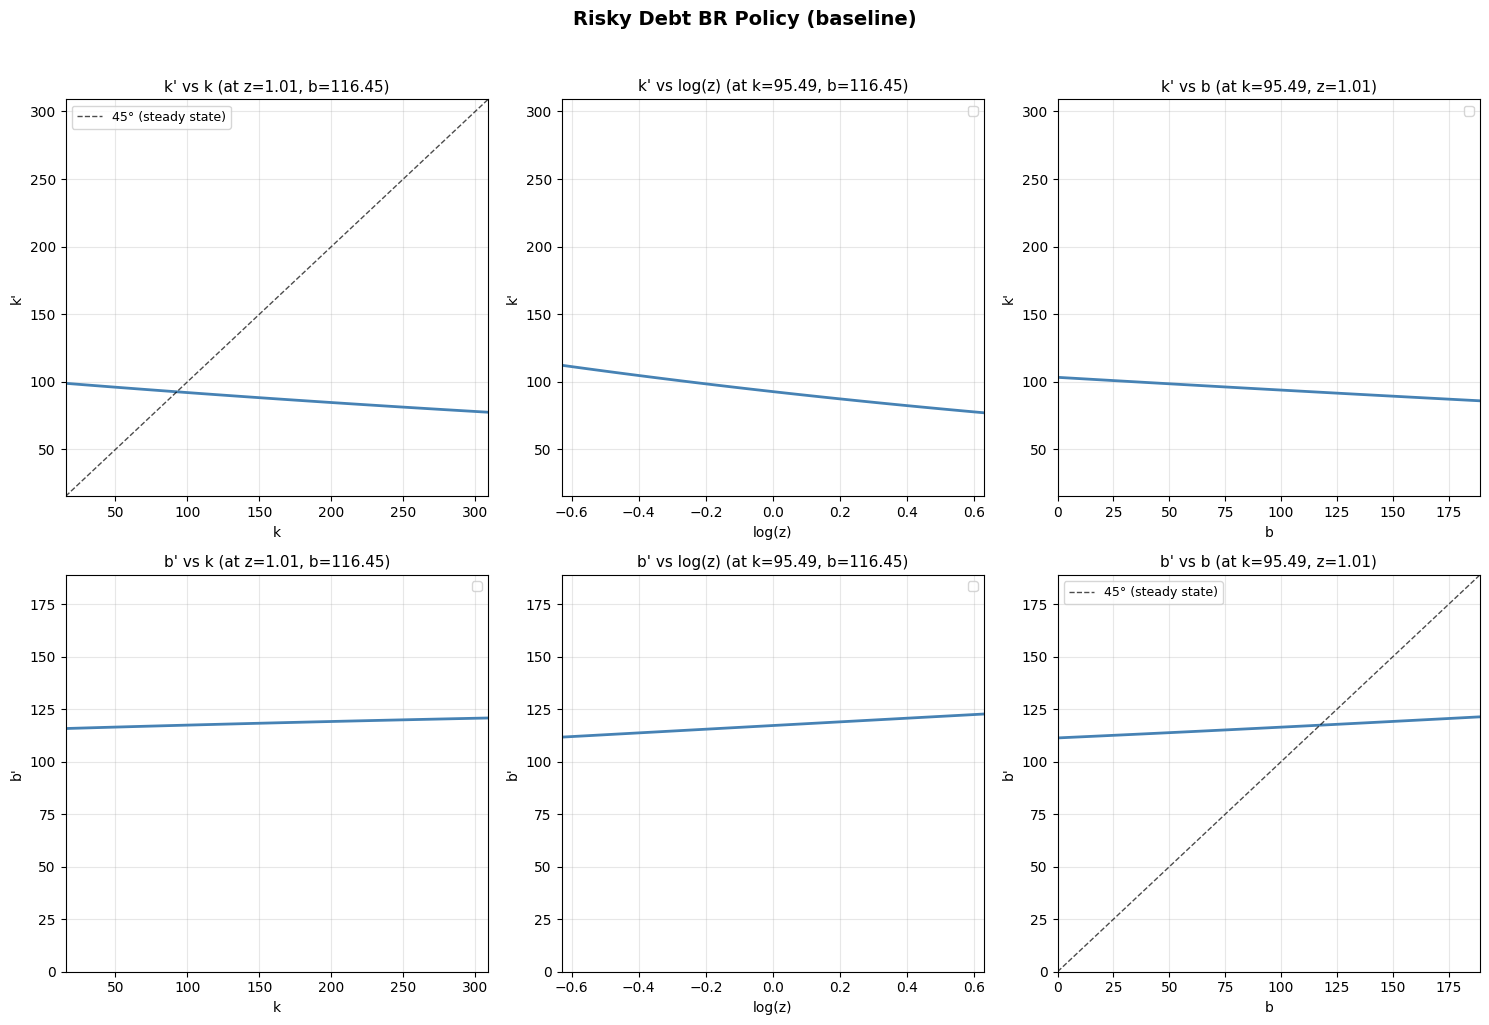

In [27]:
# =============================================================================
# 3.5.2 Risky Debt Policy Visualization (2D Panels)
# =============================================================================

from src.utils.plotting import plot_policy_panels

# Find steady state for risky model
ss_risky = get_steady_state_policy(result_risky_br, k_bounds=k_bounds, 
                                    logz_bounds=logz_bounds, b_bounds=b_bounds)

print(f"Risky Debt Steady State ({risky_scenario}):")
print(f"  k* = {ss_risky['k_star_val']:.4f}")
print(f"  b* = {ss_risky['b_star_val']:.4f}")

# Evaluate policy on grid
grid_risky = evaluate_policy(result_risky_br, k_bounds=k_bounds, 
                             logz_bounds=logz_bounds, b_bounds=b_bounds,
                             fixed_k_val=ss_risky['k_star_val'],
                             fixed_b_val=ss_risky['b_star_val'])

# 2x3 panel plot for risky model
fig = plot_policy_panels(grid_risky, suptitle=f"Risky Debt BR Policy ({risky_scenario})")
plt.savefig(os.path.join(FIGURES_DIR, "risky_br_policy.png"), dpi=150, bbox_inches='tight')
plt.show()

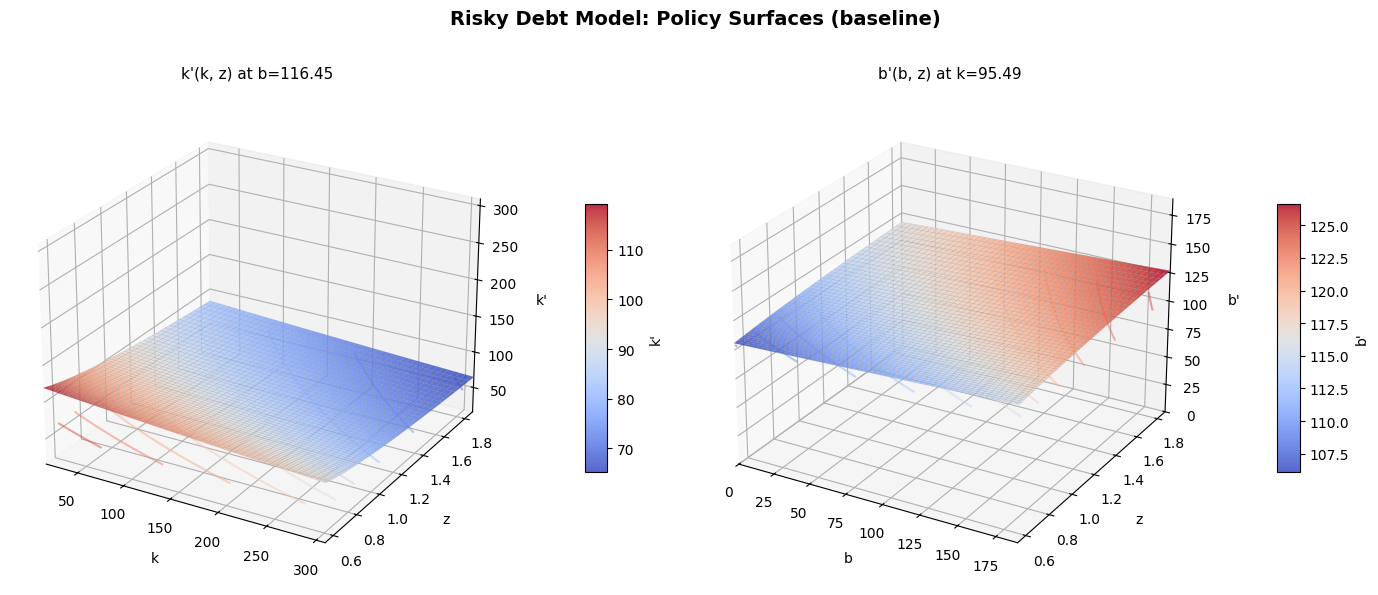

In [28]:
# =============================================================================
# 3.5.3 Risky Debt: 3D Policy Surface Visualization
# =============================================================================

from src.utils.plotting import plot_3d_policy_panels

# Risky Model 3D Surfaces
fig = plot_3d_policy_panels(grid_risky,
                            suptitle=f"Risky Debt Model: Policy Surfaces ({risky_scenario})",
                            show_contour_projection=True)
plt.savefig(os.path.join(FIGURES_DIR, "risky_3d_policies.png"), dpi=150, bbox_inches='tight')
plt.show()

In [29]:
# =============================================================================
# 3.6 Summary: All Figures Saved
# =============================================================================

print("\n" + "=" * 70)
print("ALL FIGURES SAVED")
print("=" * 70)
print(f"Directory: {FIGURES_DIR}")
print()

import glob
figures = glob.glob(os.path.join(FIGURES_DIR, "*.png"))
for fig_path in sorted(figures):
    print(f"  - {os.path.basename(fig_path)}")

print("\n" + "=" * 70)
print("EXPERIMENT SUMMARY")
print("=" * 70)
print(f"Basic Model Scenarios: {basic_scenarios}")
print(f"  Methods per scenario: {methods}")
print(f"  Total basic runs: {len(basic_scenarios) * len(methods)}")
print(f"\nRisky Debt Scenarios: {risky_scenarios}")
print(f"  Total risky runs: {len(risky_scenarios)}")
print(f"\nTotal training runs: {len(basic_scenarios) * len(methods) + len(risky_scenarios)}")
print("=" * 70)


ALL FIGURES SAVED
Directory: ../results/part1-demo/figures

  - baseline_validation.png
  - basic_3d_cross_scenario.png
  - basic_3d_policy.png
  - basic_loss_curves.png
  - basic_loss_curves_baseline.png
  - basic_loss_curves_by_scenario.png
  - basic_loss_curves_fixed_cost.png
  - basic_loss_curves_smooth_cost.png
  - basic_policy_comparison.png
  - basic_policy_comparison_baseline.png
  - basic_policy_comparison_fixed_cost.png
  - basic_policy_comparison_smooth_cost.png
  - basic_scenario_comparison_br.png
  - basic_scenario_comparison_er.png
  - basic_scenario_comparison_lr.png
  - data_format_comparison.png
  - risky_3d_policies.png
  - risky_br_loss_curves.png
  - risky_br_policy.png
  - risky_debt_diagnostics.png

EXPERIMENT SUMMARY
Basic Model Scenarios: ['baseline', 'smooth_cost', 'fixed_cost']
  Methods per scenario: ['lr', 'er', 'br']
  Total basic runs: 9

Risky Debt Scenarios: ['baseline']
  Total risky runs: 1

Total training runs: 10
